In [1]:
import scperturb as scp 
import urllib.request
import os
import scanpy as sc 
import numpy as np
from matplotlib import pyplot as plt
from gsnn_lib.proc import omnipath 
import pandas as pd
import torch

from gsnn.models.GSNN import GSNN 
from gsnn.models.NN import NN
from hnet.models.HyperNet import HyperNet

from gsnn_lib.proc.sc.load import get_SrivatsanTrapnell2020, get_AissaBenevolenskaya2021, load_scp_dataset
from gsnn_lib.data.scSampler import scSampler

from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score

from hnet.train.hnet import init_hnet

import umap
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import gc 
from scipy.stats import ks_2samp, mannwhitneyu


%load_ext autoreload
%autoreload 2

/home/teddy/miniconda3/envs/gsnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


KeyboardInterrupt: 

In [2]:
fnames = os.listdir('../../sc_data/PROC/')
drugs = np.unique([f.split('_')[2] for f in fnames])[:-1] 
data = torch.load('../../sc_data/' + 'data.pt')

In [3]:
res_dict = torch.load('../../sc_output_not/res_dict.pt')
sampler = res_dict['sampler']
os.chdir('../')
T = res_dict['T']
f = res_dict['f']
args = res_dict['args']
device = 'cuda'

In [ ]:
plt.figure()
plt.plot(res_dict['mmds'])
plt.show()

In [4]:
#X,y = sampler.sample(0, 10)
#T(X.cuda(), 1).squeeze().std(0)

In [5]:
def plot_f_score(reducer, f, ax, n=25, x_min=-15, x_max=15, y_min=-15, y_max=15):

    # Define the grid in PCA space
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, n), np.linspace(y_min, y_max, n))

    # Flatten the grid to pass through the inverse transform
    grid_points = np.c_[xx.ravel(), yy.ravel()]

    # Convert the grid points back to the original space
    original_space_points = reducer.inverse_transform(grid_points)

    # Convert to torch tensor and move to the appropriate device
    original_space_points_tensor = torch.tensor(original_space_points, dtype=torch.float32).to(device)

    # Predict f_score using f_dict[3]()
    with torch.no_grad(): 
        f_score = f(original_space_points_tensor).detach().cpu().numpy()

    # Reshape the f_score to match the grid shape
    f_score_grid = f_score.reshape(xx.shape)

    # Plot the f_score in the PCA space
    cbar = ax.contourf(xx, yy, f_score_grid, levels=50, cmap='viridis')
    plt.colorbar(cbar, label='f_score')

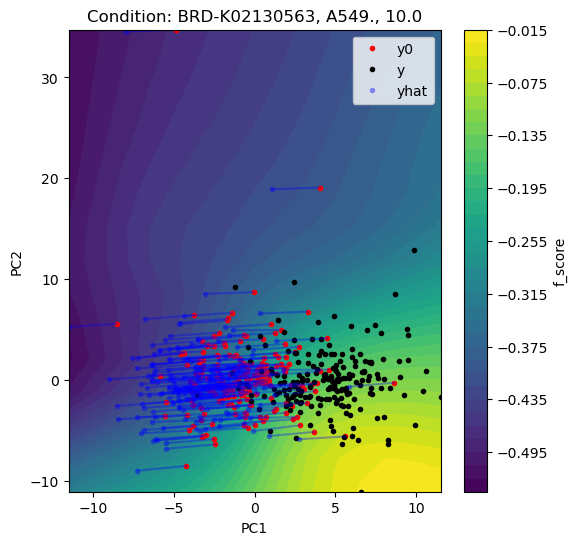

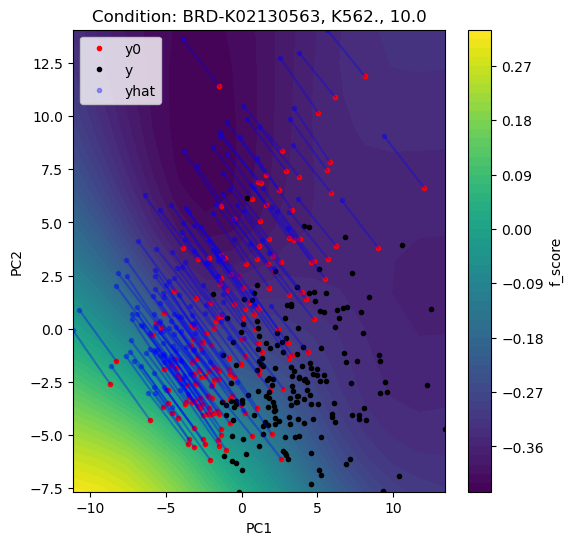

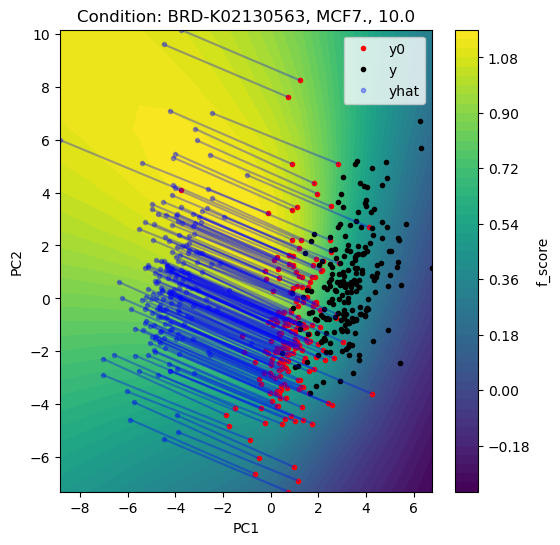

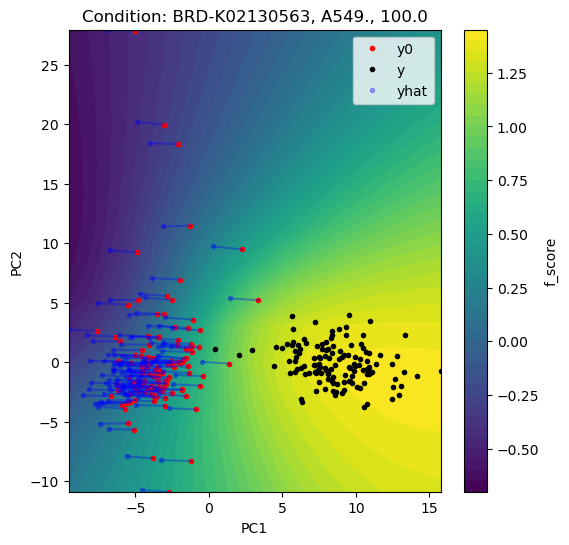

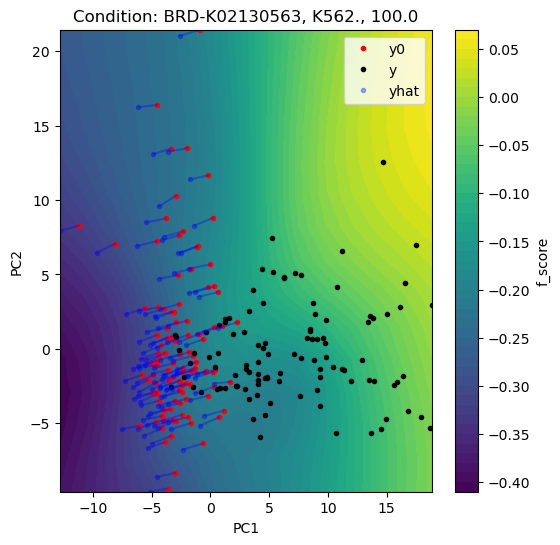

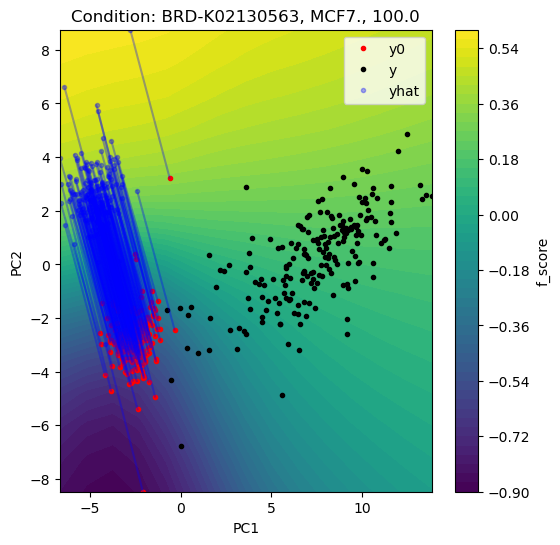

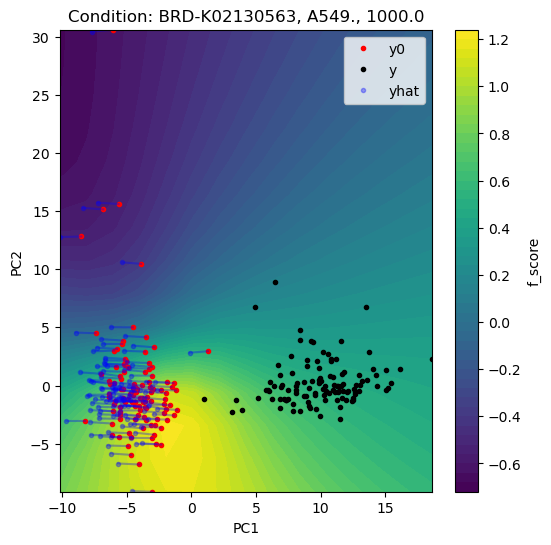

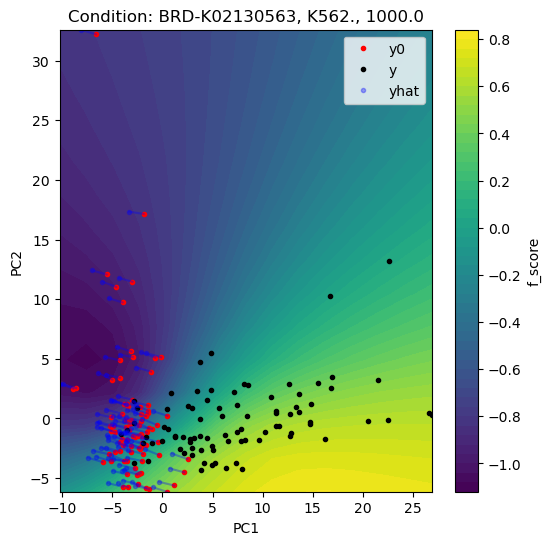

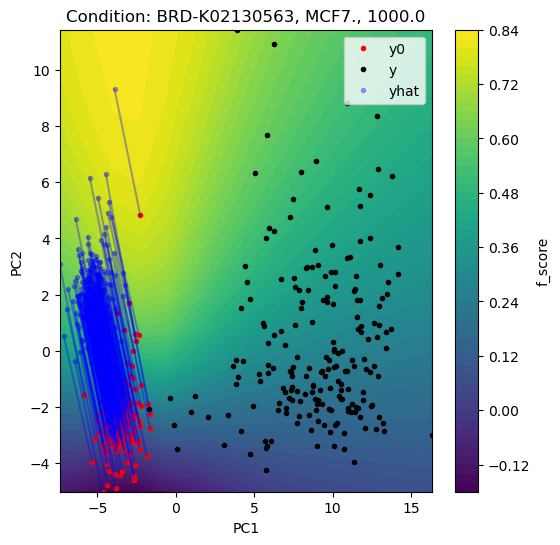

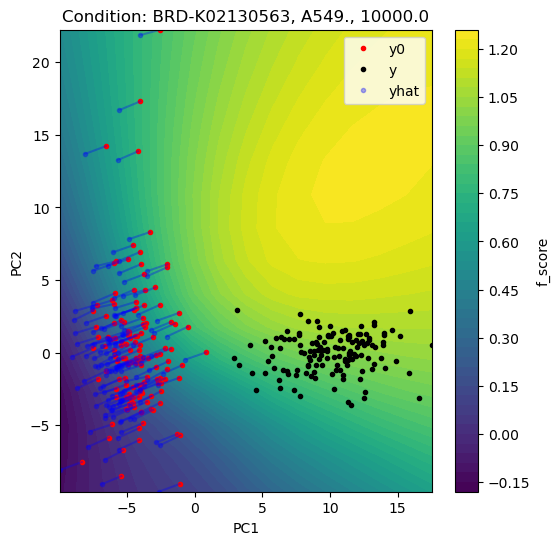

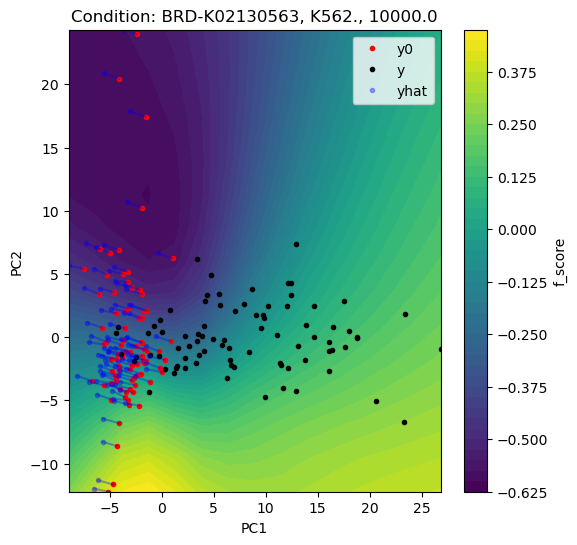

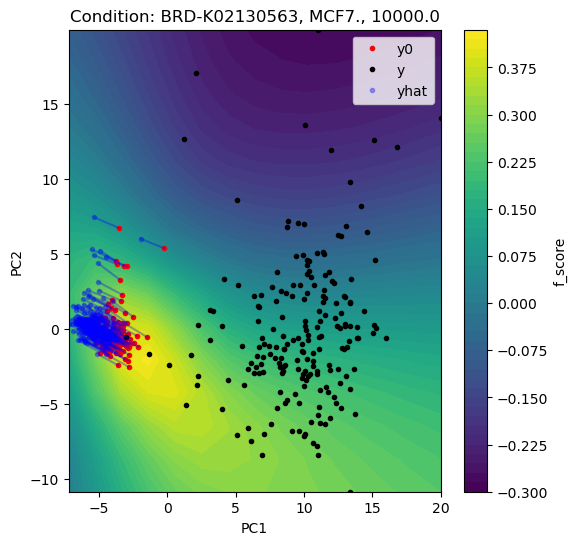

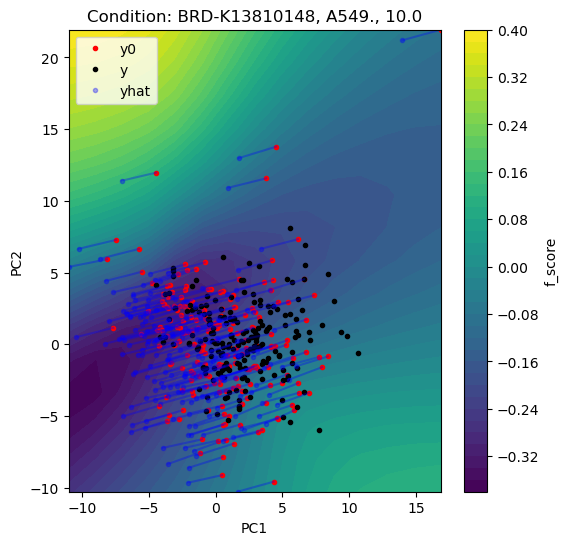

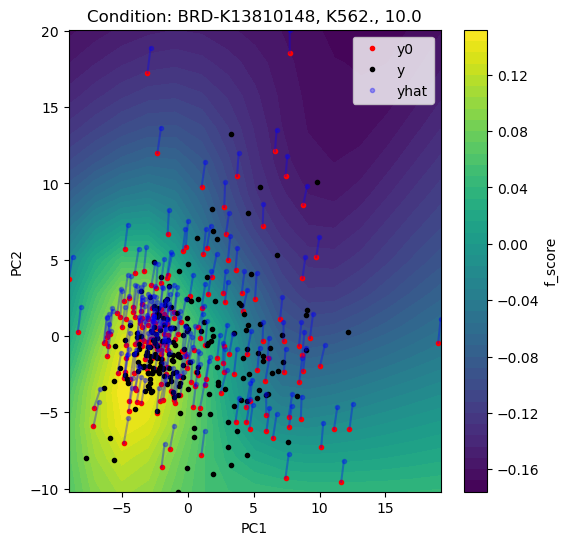

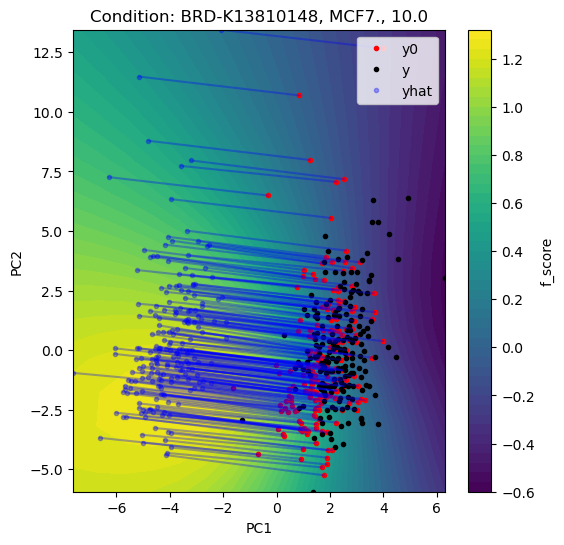

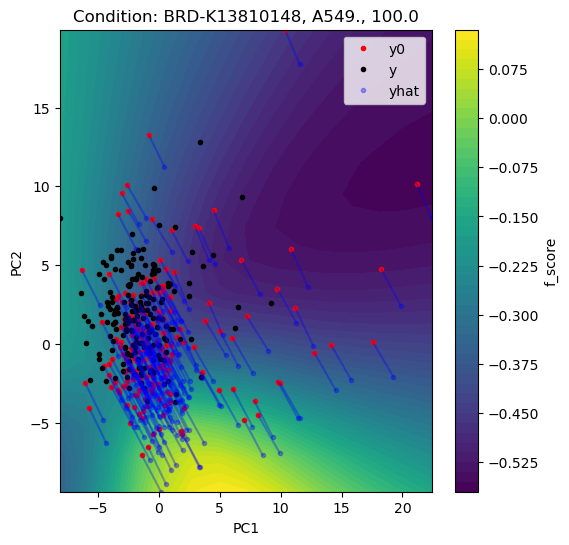

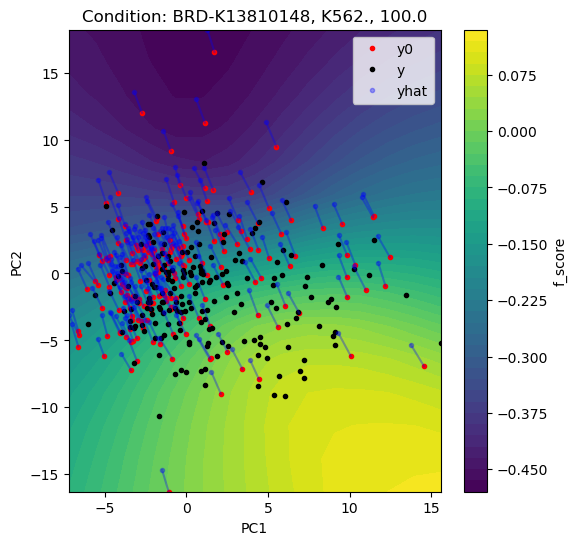

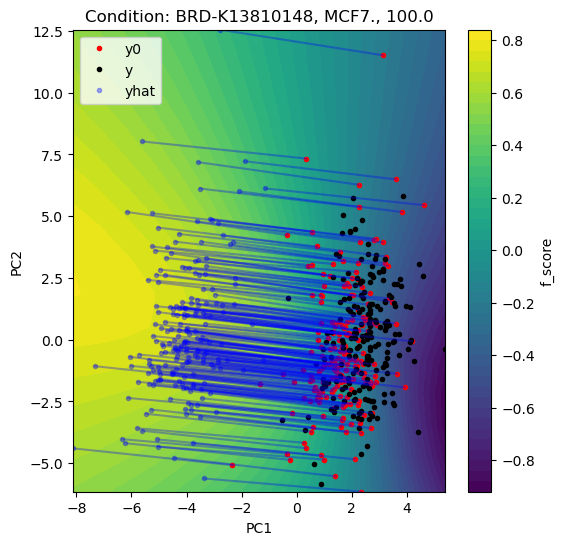

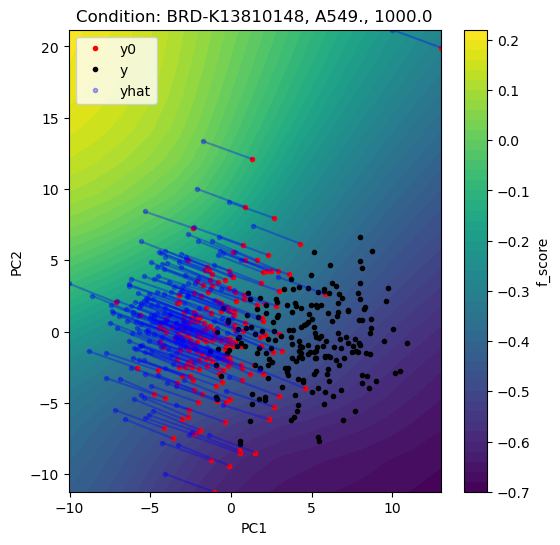

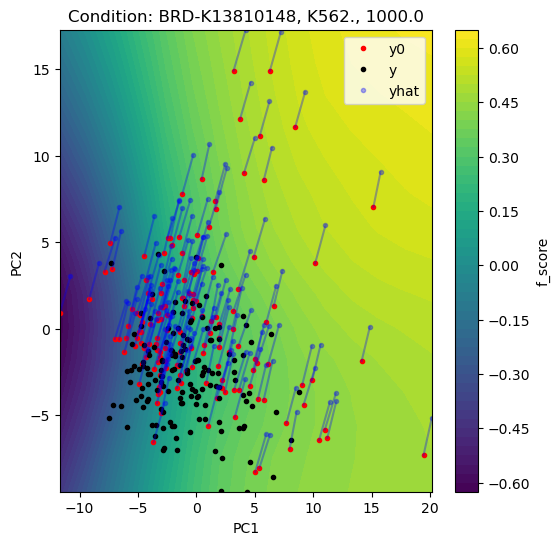

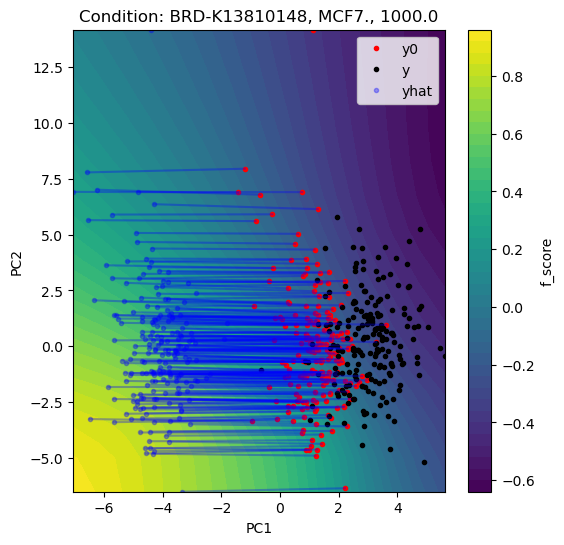

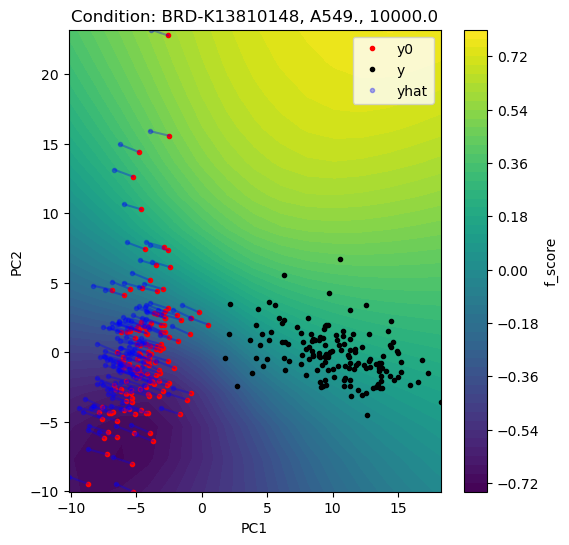

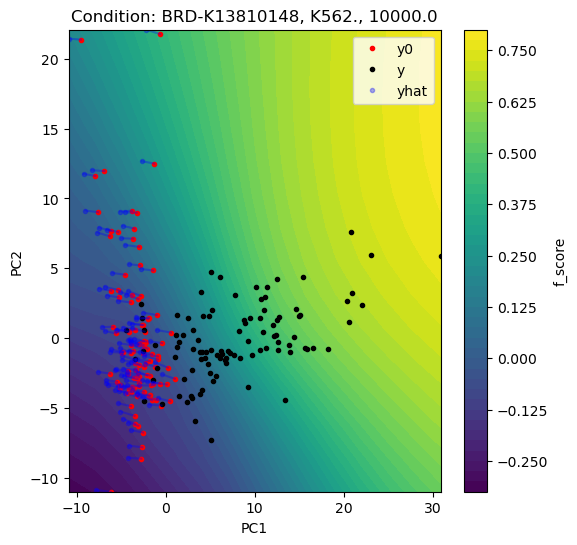

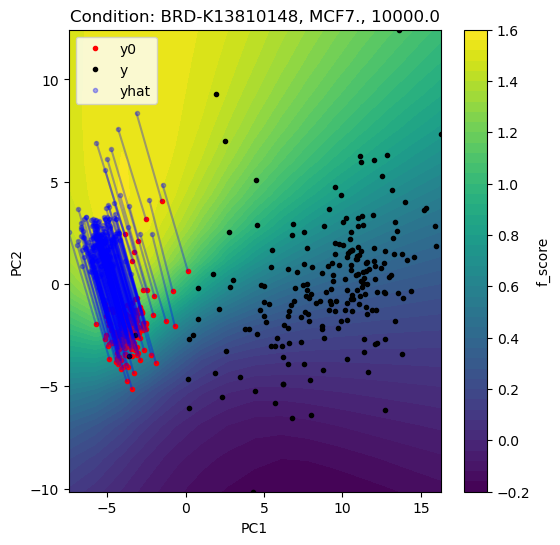

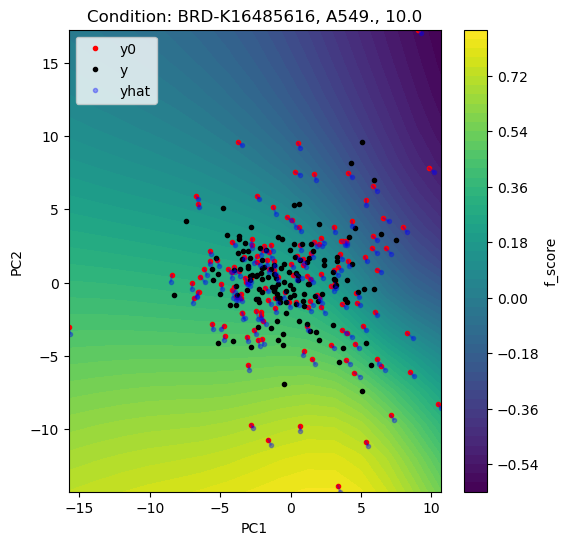

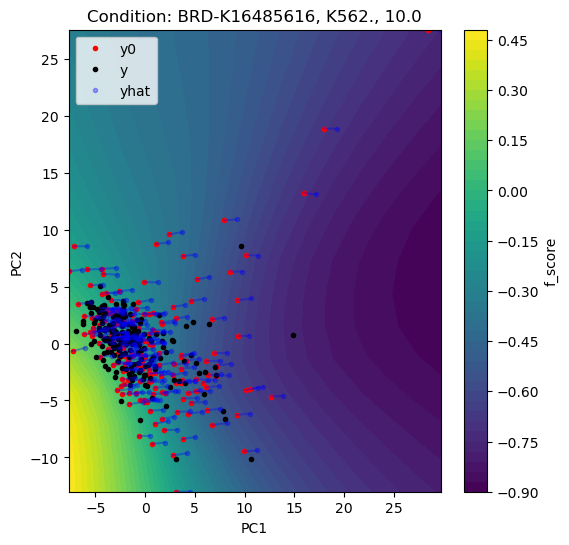

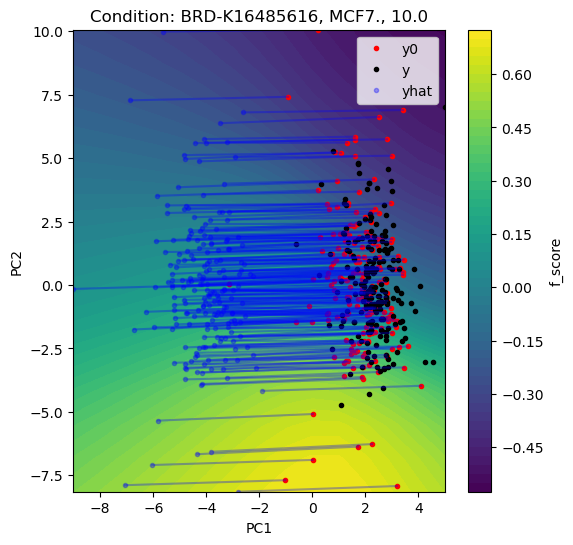

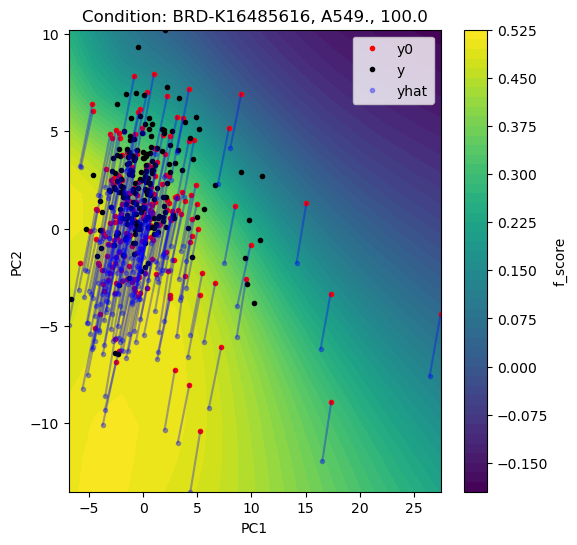

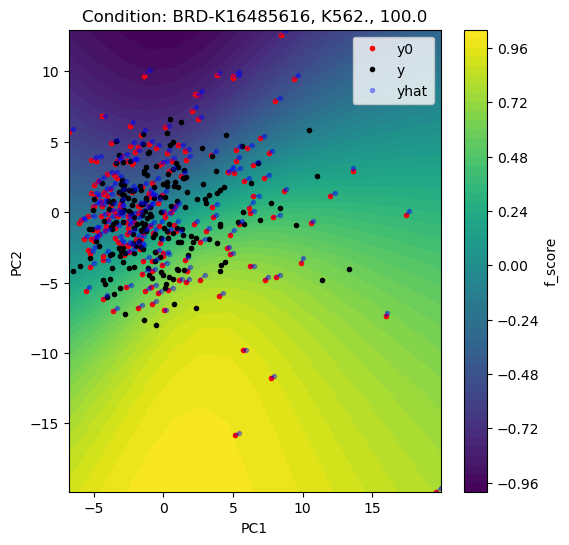

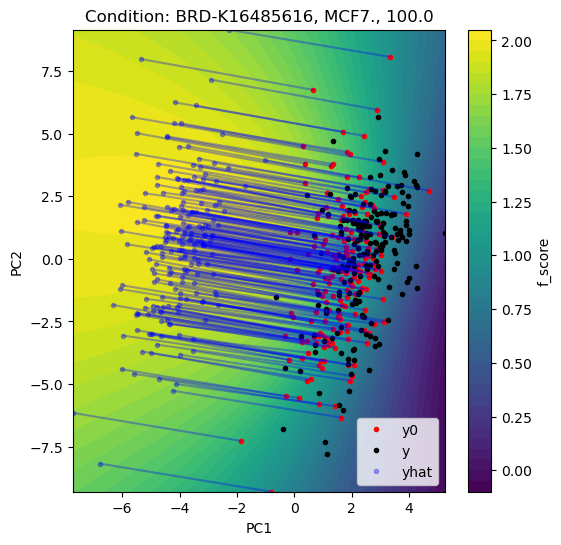

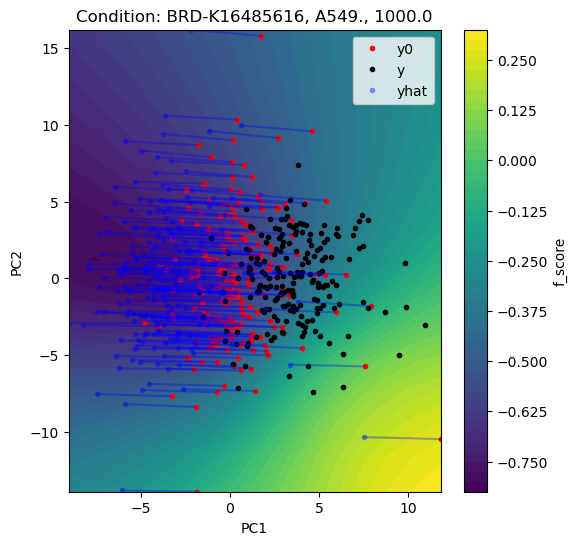

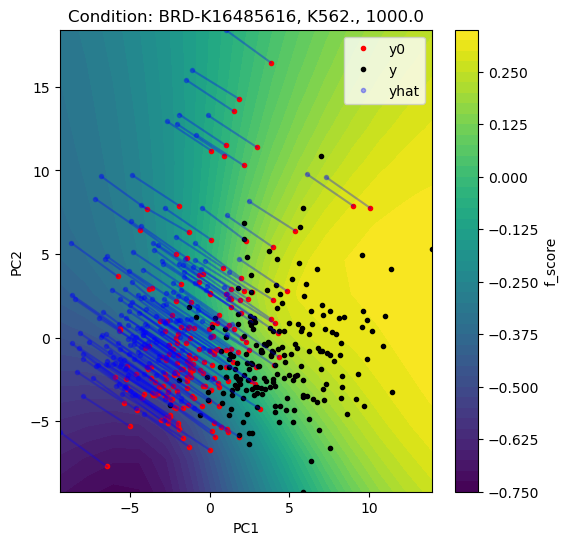

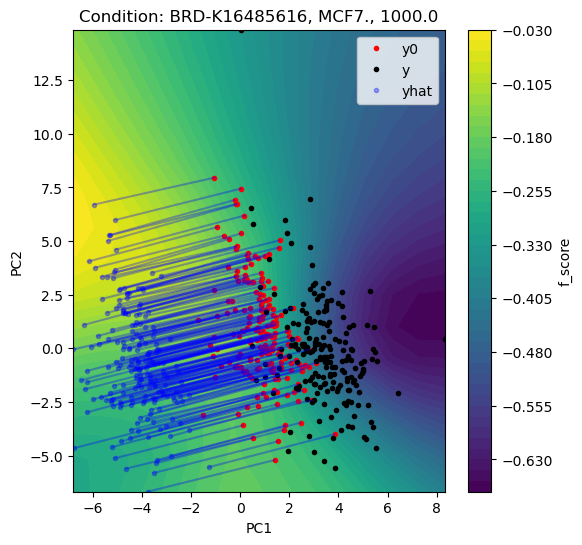

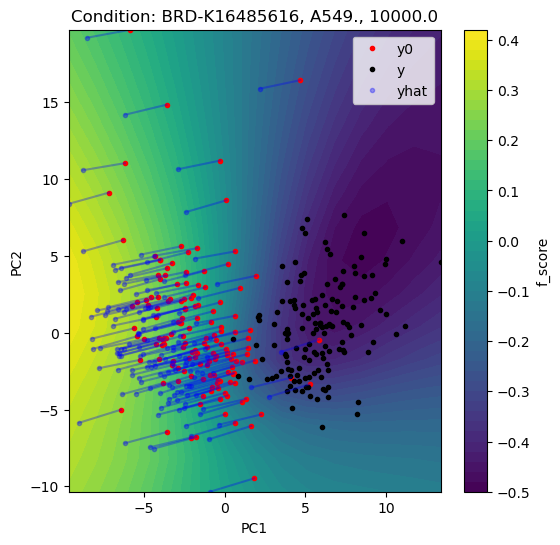

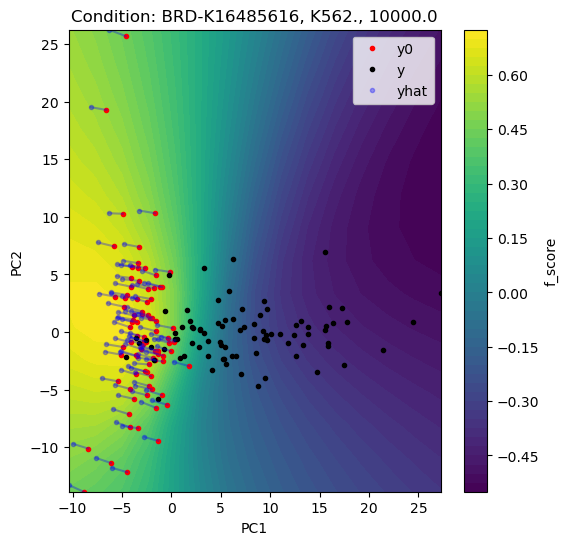

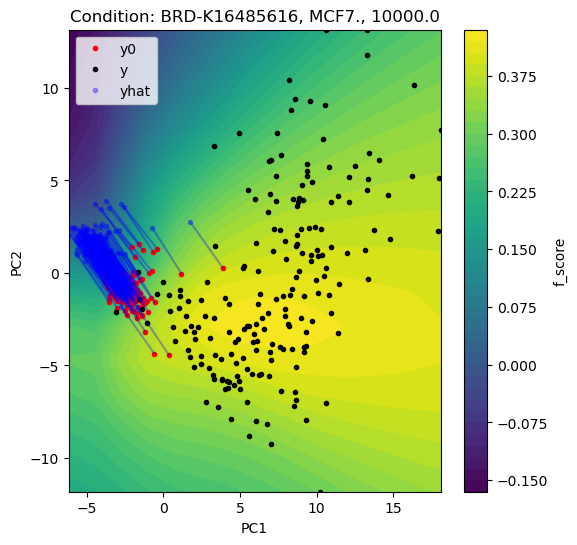

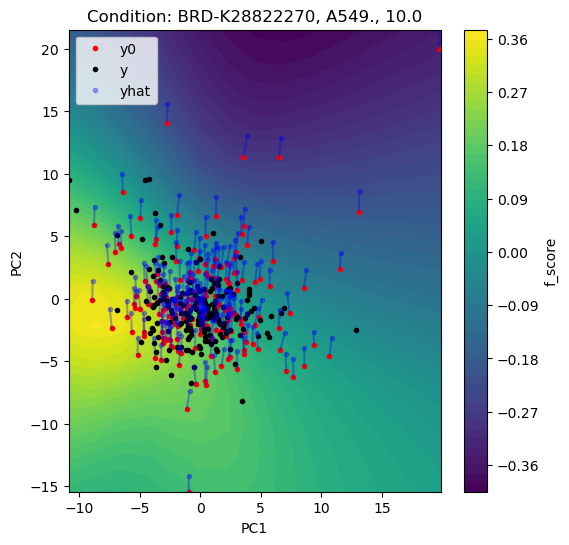

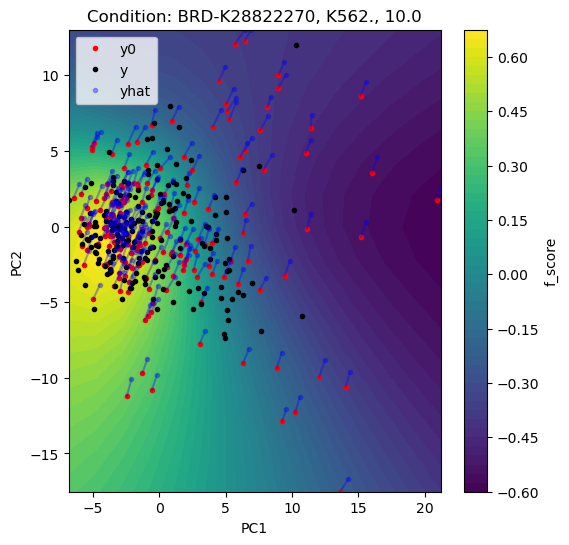

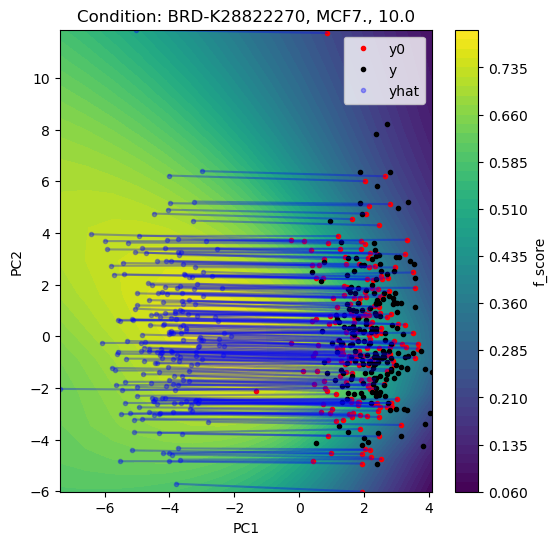

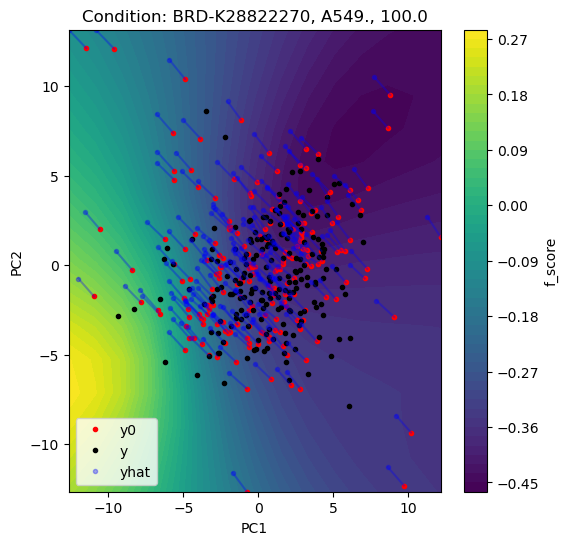

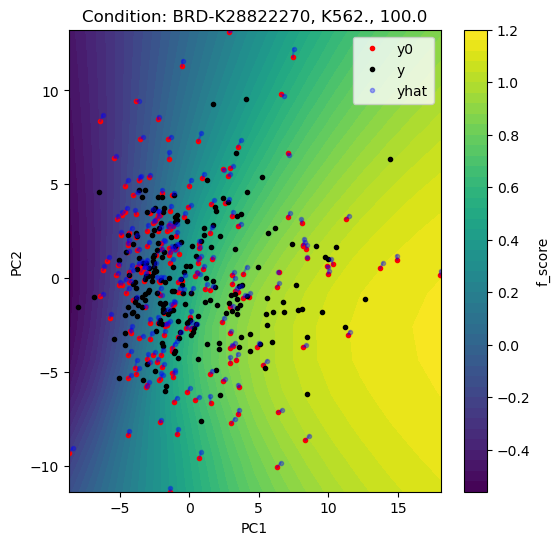

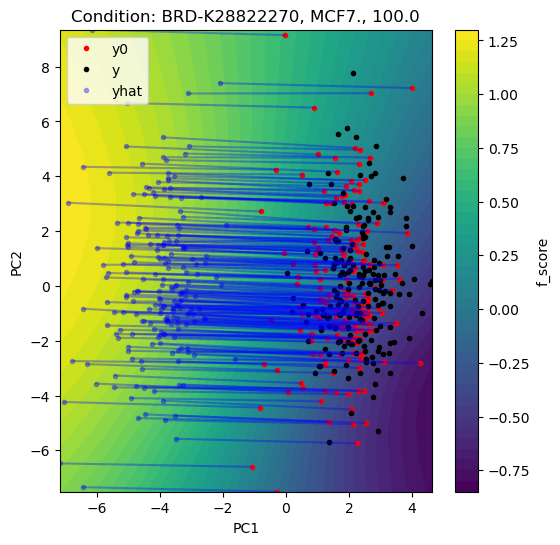

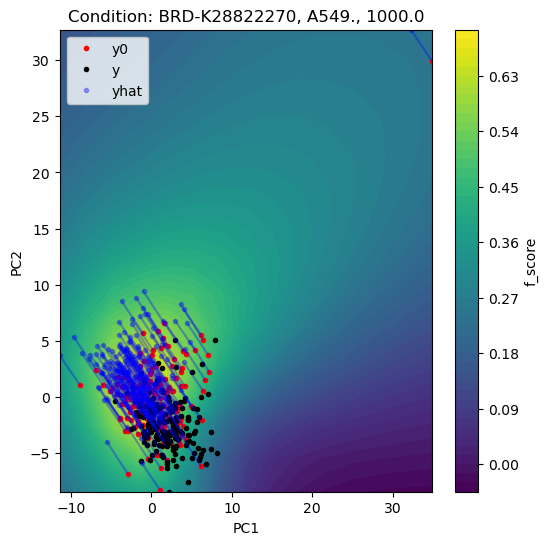

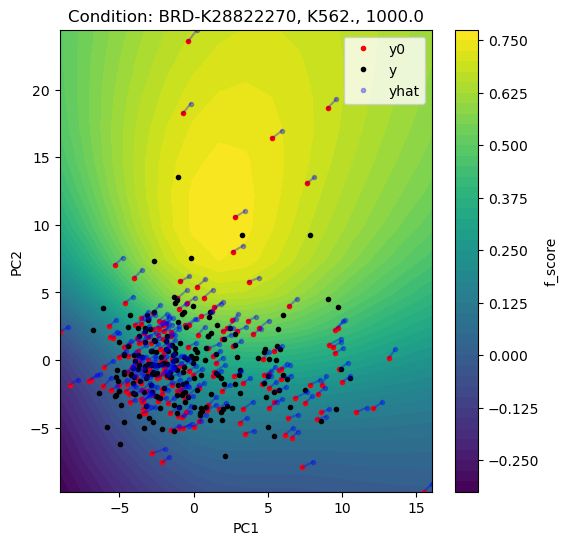

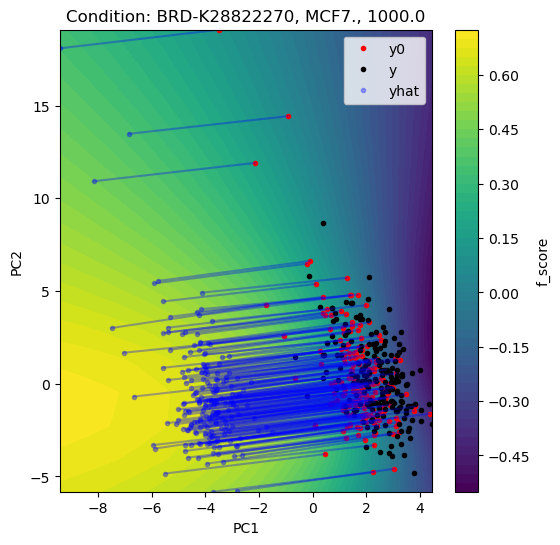

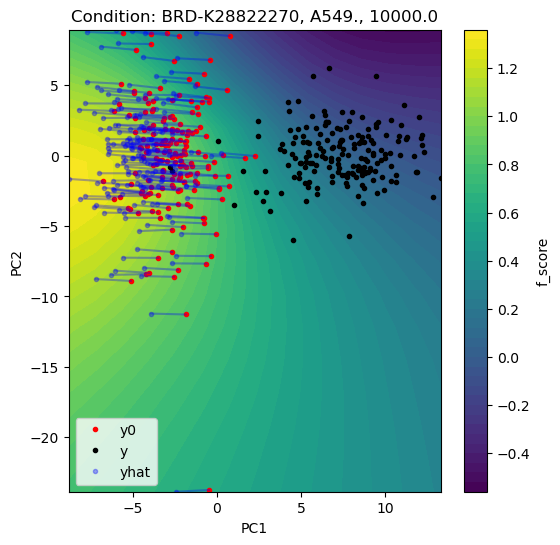

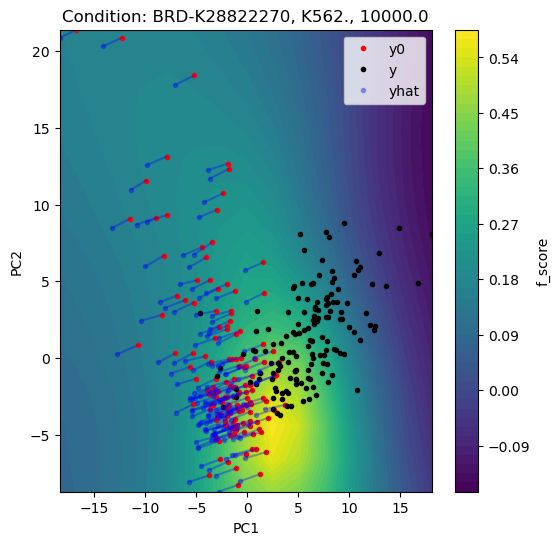

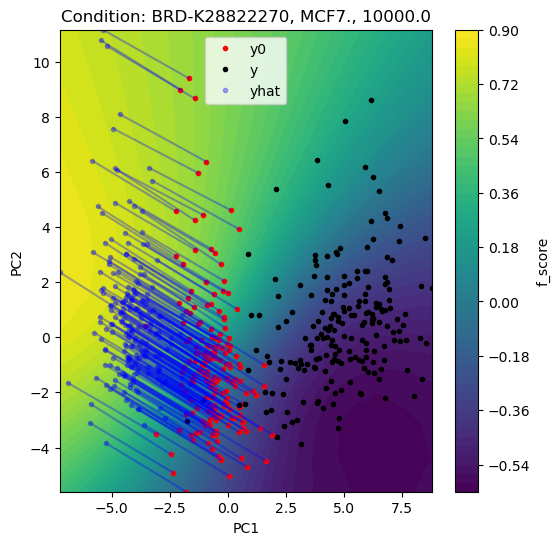

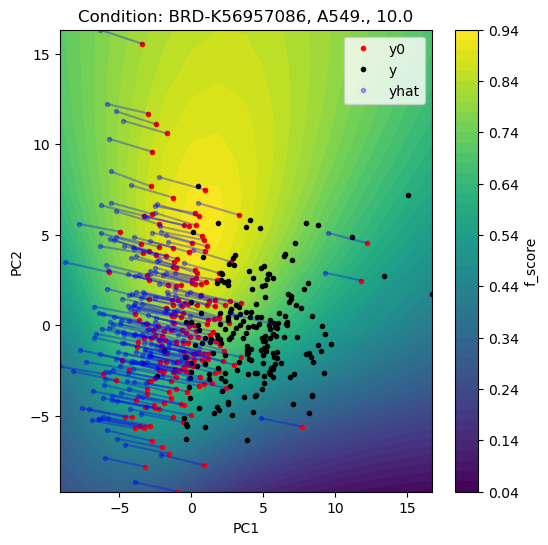

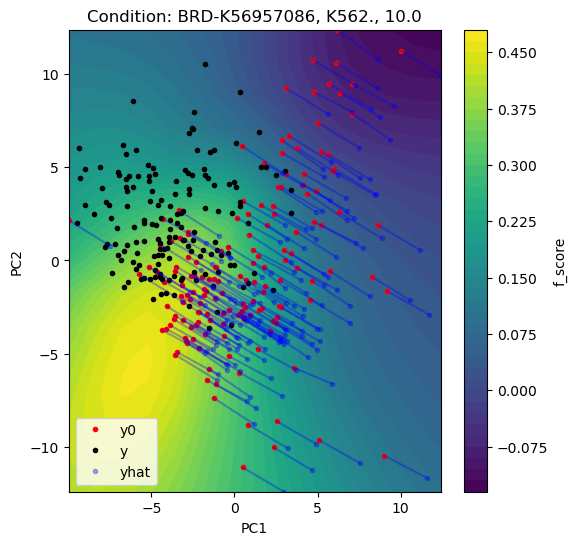

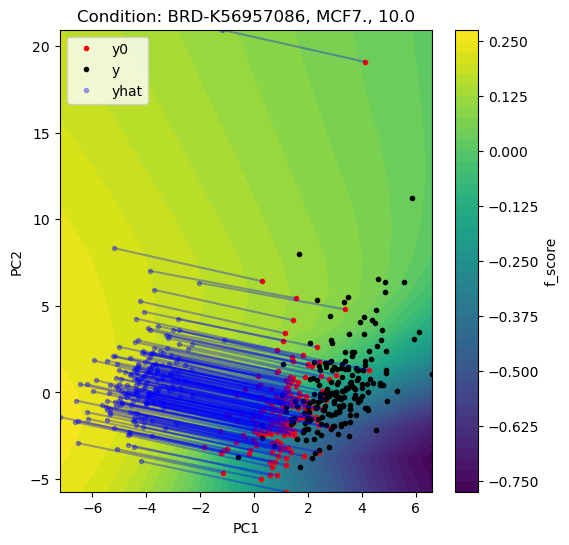

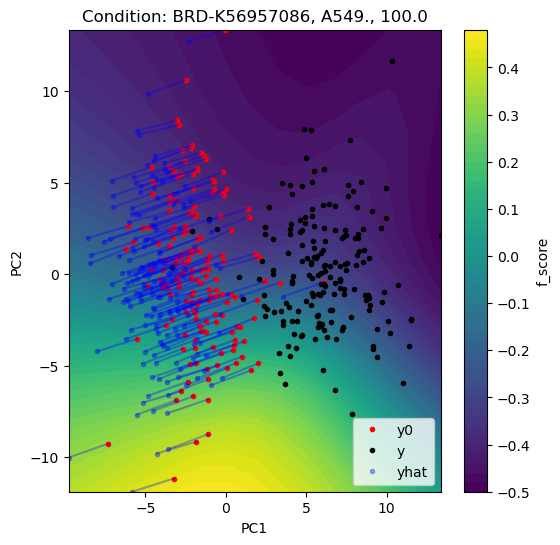

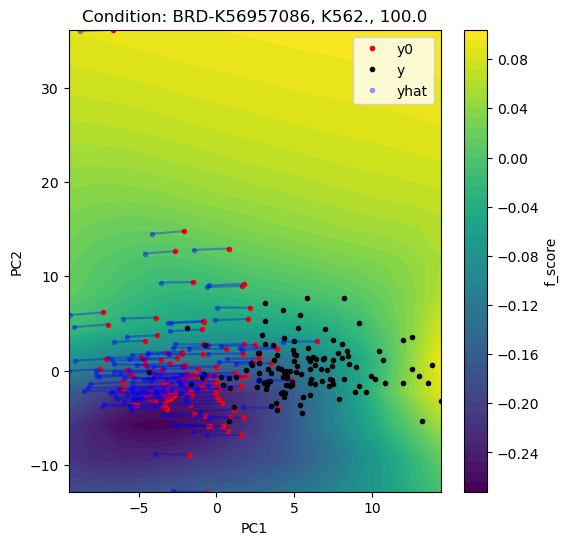

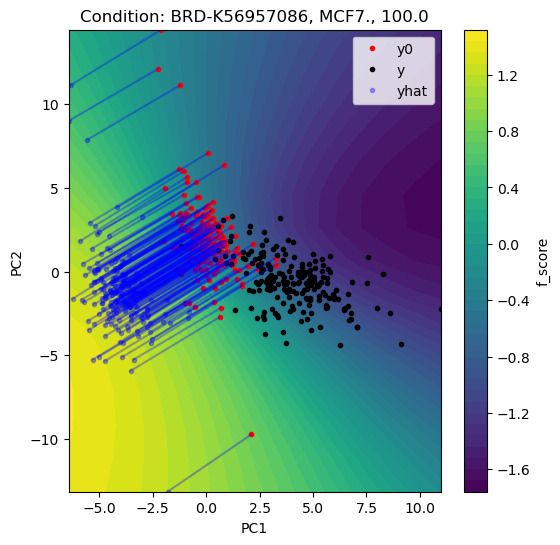

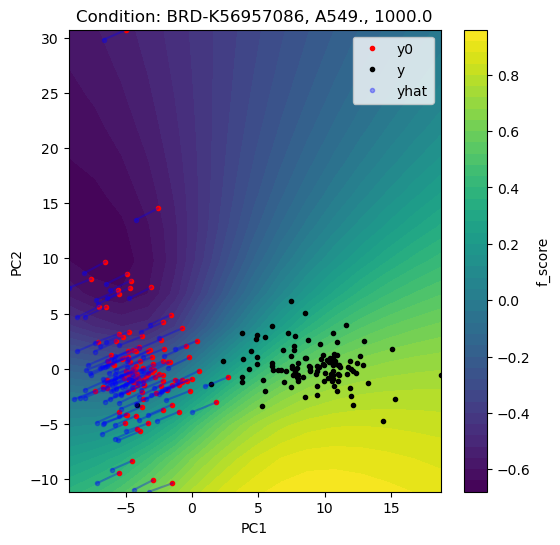

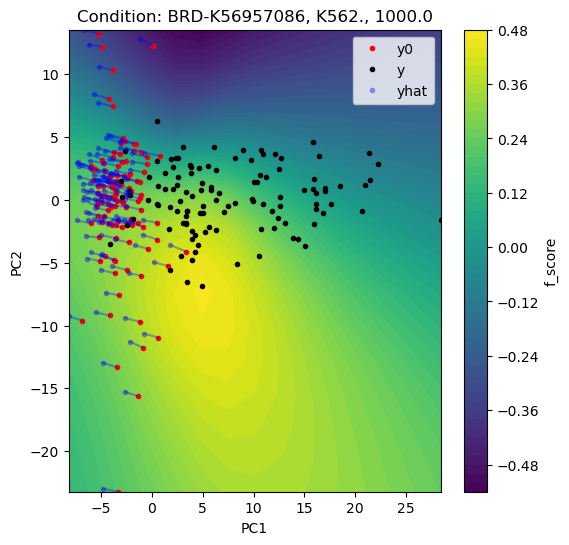

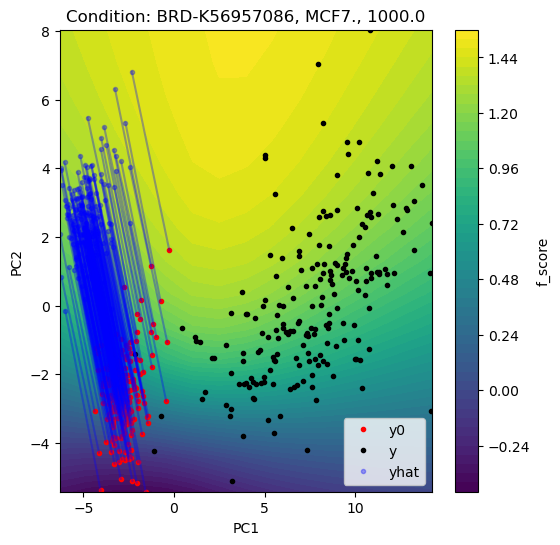

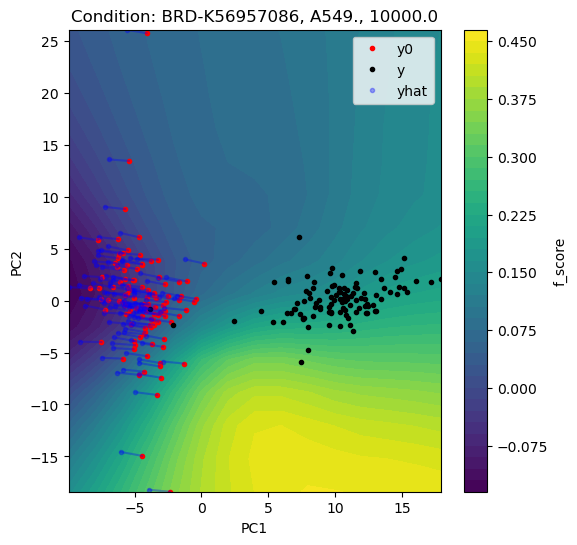

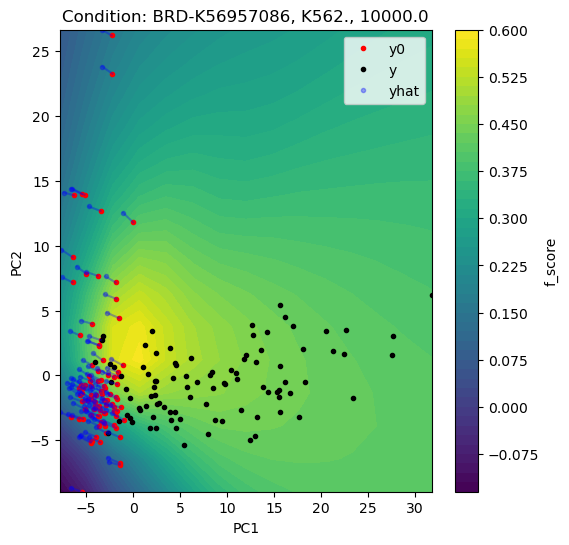

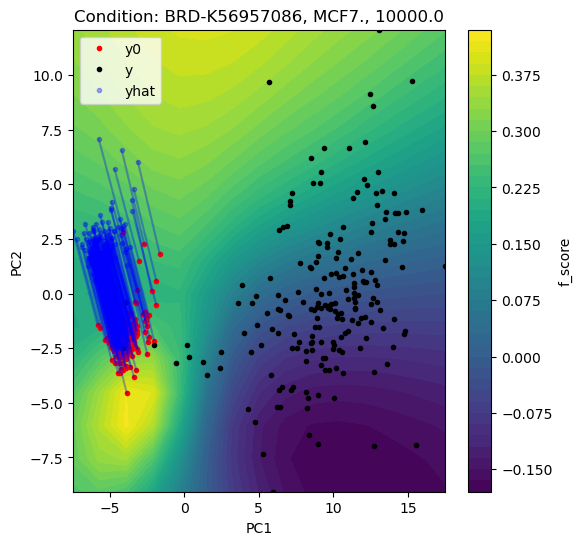

In [6]:

for i in range(len(sampler)):

    cond = sampler.conditions.iloc[i]
    drg_ = cond.drug 
    cell_ = cond.cell_line 
    dose_ = cond.dose

    with torch.no_grad():
        X,y = sampler.sample(i, batch_size=200)
        T = T.to(device)

        delta = [] 
        for idx in torch.split(torch.arange(X.shape[0]), 25): 
            delta.append(T(X[idx].to(device)).detach().cpu())
        delta = torch.cat(delta, dim=0)

    y0 = X[:, data.X2Y0_idxs].detach().cpu().numpy() 
    y = y.detach().cpu().numpy()
    yhat = delta.detach().cpu().numpy() + y0

    # dim red on each condition to better separate perturbation effects 
    reducer = PCA(2)
    #reducer = umap.UMAP(2, metric='euclidean')
    pcs = reducer.fit(np.concatenate([y0, y, yhat], axis=0))

    pc_y0 = reducer.transform(y0)
    pc_y = reducer.transform(y)
    pc_yhat = reducer.transform(yhat)

    x_min = np.min([pc_y0[:,0], pc_y[:,0], pc_yhat[:,0]])
    x_max = np.max([pc_y0[:,0], pc_y[:,0], pc_yhat[:,0]])
    y_min = np.min([pc_y0[:,1], pc_y[:,1], pc_yhat[:,1]])
    y_max = np.max([pc_y0[:,1], pc_y[:,1], pc_yhat[:,1]])

    f, ax = plt.subplots(1,1, figsize=(6,6))
    plot_f_score(reducer, f_dict[i], ax=ax, x_min=x_min, x_max=x_max, y_min=y_min, y_max=y_max, n=15) 
    plt.plot(*pc_y0.T, 'r.', label='y0')
    plt.plot(*pc_y.T, 'k.', label='y')
    plt.plot(*pc_yhat.T, 'b.', label='yhat', alpha=0.33)
    for ii in range(pc_y0.shape[0]): 
        plt.plot((pc_y0[ii,0], pc_yhat[ii, 0]),(pc_y0[ii,1], pc_yhat[ii, 1]),  'b-', alpha=0.33)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'Condition: {drg_}, {cell_}, {dose_}')
    plt.legend()
    plt.show()

In [7]:

line_ = 'A549.'
dose_ = 10000.0

good_drugs = 'BRD-K56957086,BRD-K28822270,BRD-K16485616,BRD-K13810148,BRD-K02130563'.split(',')
for drug_ in good_drugs:
    pert_fnames = [] 
    for f in fnames: 
        tp, id, drg, ds, ln = f[:-2].split('_')
        #print(tp, id, drg, ds, ln);3/0
        if (tp == 'perturbed') and (drg == drug_) and (ln == line_) and (ds == str(dose_)):
            pert_fnames.append(f) 
    print(len(pert_fnames)) 

    ctrl_fnames = []
    for f in fnames: 
        tp, id, drg, ds, ln = f[:-2].split('_')
        if (ln == line_) and (tp == 'unperturbed'):
            ctrl_fnames.append(f)
    print(len(ctrl_fnames))     

    y_pert = torch.stack([torch.load('../../sc_data/PROC/'+x) for x in pert_fnames], dim=0)
    y_ctrl = torch.stack([torch.load('../../sc_data/PROC/'+x) for x in ctrl_fnames], dim=0)[:, data.X2Y0_idxs]


    ys = torch.cat([y_pert, y_ctrl], dim=0)
    reducer = PCA(n_components=2)
    #reducer = umap.UMAP(2)
    reducer.fit(ys.detach().cpu().numpy())
    u_pert = reducer.transform(y_pert.detach().cpu().numpy())
    u_ctrl = reducer.transform(y_ctrl.detach().cpu().numpy())

    plt.figure()
    plt.title(f'{drug_}, {line_}, {dose_}')
    plt.plot(u_ctrl[:,0], u_ctrl[:,1], 'b.', alpha=0.2, label='control')
    plt.plot(u_pert[:,0], u_pert[:,1], 'r.', alpha=0.5, label='perturbed')
    plt.legend() 
    plt.show() 


108
3772


FileNotFoundError: [Errno 2] No such file or directory: '../../sc_data/PROC/perturbed_202668_BRD-K56957086_10000.0_A549.pt'